# STONED-SELFIES 

## Generation of synthetic data via the STONED-SELFIES algorithm


### Exploration of the chemical space of neighborhoods of known of KRAS inhibitors. 


This notebook builds upon some of the code and ideas developed in <a href="https://github.com/aspuru-guzik-group/quantum-generative-models">/aspuru-guzik-group/quantum-generative-models/ </a> (esp. the script `stoned_sim.py` within `stoned_algorithm`). See also  <a href="https://www.nature.com/articles/s41587-024-02526-3"> Nature Reports s41587-024-02526-3 </a> and  <a href="https://arxiv.org/abs/2402.08210">arXiv/2402.08210 </a> for the more thorough arXiv version. 

The `cyba` module has been imported from <a href="https://github.com/lich-uct/syba">/lich-uct/syba/ </a>.

The files `syba.csv.gz`and `syba4.csv.gz` where obtained from <a href="https://anaconda.org/LICH/syba/files">/anaconda.org/LICH/syba/files</a>.



In [1]:
# Imports

import os 
import pandas as pd 
import numpy as np
import matplotlib
import time 
import selfies as sf
import rdkit
import random
import tqdm

from selfies import encoder, decoder
from filter_ import apply_filters
from rdkit import Chem, RDLogger
from rdkit.Chem import MolFromSmiles as smi2mol
from rdkit.Chem import MolToSmiles as mol2smi
from rdkit.Chem import AllChem, Mol
from rdkit.DataStructs.cDataStructs import TanimotoSimilarity
from rdkit.Chem.AtomPairs.Sheridan import GetBPFingerprint, GetBTFingerprint
from rdkit.Chem.Pharm2D import Generate, Gobbi_Pharm2D
from rdkit.Chem import Draw

from syba.syba import SybaClassifier

## $\S 0.$ Datafiles

Our starting point is the initial dataset used in  <a href="https://www.nature.com/articles/s41587-024-02526-3"> Nature Reports s41587-024-02526-3 </a>, it consist of 645 known BRAF inhibitors. We keep from the dataset the SMILES representation of the molecules and add their SELFIES representation using the `encoder` function from the `selfies` module. 

Our starting point is the initial dataset used in, it consist of 645 known BRAF inhibitors. We keep from the dataset the SMILES representation of the molecules and add their SELFIES representation using the `encoder` function from the `selfies` module.  

We also upload the files that will be used to filter out the molecules generated by the algorithm. 

In [2]:
directory_path = './DATA'
kras_inhibitors = os.path.join(directory_path, 'KRAS_G12D_inhibitors_update202209_updated.csv')
kras_inhibitors_df = pd.read_csv(kras_inhibitors)

In [3]:
kras_inhibitors_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 645 entries, 0 to 644
Data columns (total 5 columns):
 #   Column                       Non-Null Count  Dtype 
---  ------                       --------------  ----- 
 0   id                           645 non-null    int64 
 1   smiles                       645 non-null    object
 2   KRAS G12D SPR KD  (nM)       216 non-null    object
 3   KRAS G12D binding IC50 (nM)  628 non-null    object
 4   pERK IC50 (nM)               418 non-null    object
dtypes: int64(1), object(4)
memory usage: 25.3+ KB


In [4]:
kras_inhibitors_df.head()

,id,smiles,KRAS G12D SPR KD (nM),KRAS G12D binding IC50 (nM),pERK IC50 (nM)
0,1,CN1[C@H](COc2nc3cc(-c4cc(O)cc5ccccc45)ncc3c(N3...,97.7,124.7,3159.1
1,2,CN1[C@H](COc2nc(N3CC(CC4)NC4C3)c(cnc(-c3cc(O)c...,2.4,2.7,721.4
2,3,Cn1c(CCOc2nc(N3CC(CC4)NC4C3)c(cnc(-c3cc(O)cc4c...,8.3,9.5,10283.1
3,4,Oc1cc2ccccc2c(-c(ncc(c2n3)c(N4CC(CC5)NC5C4)nc3...,155.7,496.2,8530
4,5,Cn1nccc1COc1nc(N2CC(CC3)NC3C2)c(cnc(-c2cc(O)cc...,294.8,722.9,8193.8


In [5]:
kras_inhibitors_df.columns

Index(['id', 'smiles', 'KRAS G12D SPR KD  (nM)', 'KRAS G12D binding IC50 (nM)',
       'pERK IC50 (nM)'],
      dtype='object')

In [6]:
source_data_df = kras_inhibitors_df.copy()

In [7]:
source_data_df.drop(['KRAS G12D SPR KD  (nM)', 'KRAS G12D binding IC50 (nM)', 'pERK IC50 (nM)'], axis=1, inplace = True)
source_data_df = source_data_df.dropna(how='any',axis=0) 
source_data_df.rename(columns={'smiles':'SMILES'}, inplace=True)
source_data_df['SMILES'] = source_data_df['SMILES'].apply(lambda x: str(x).replace(u'\xa0', u'')) #Takes away the '\xa0' characters in a SMILES
source_data_df['SMILES'] = source_data_df['SMILES'].apply(lambda x: str(x).replace(u' ', u'')) #Takes away extra spaces at the end of a SMILES
source_data_df['SMILES'] = source_data_df['SMILES'].apply(lambda x: str(x).replace(u'  ', u'')) 
source_data_df = source_data_df.astype({'id':'int'}, copy=True, errors ='raise') #Cast the id as an integer instead of a float. 
source_data_df = source_data_df.reset_index(drop=True)

*Ading SELFIES*

In [8]:
def safe_encoder(smiles):
    try:
        return sf.encoder(smiles, strict= False)
    except Exception:
        return np.nan

In [9]:
source_data_df['SELFIES'] = source_data_df['SMILES'].map(safe_encoder) #Apply sf.encoder to the 'SMILES' column when possible 

In [10]:
source_data_df.head()

,id,SMILES,SELFIES
0,1,CN1[C@H](COc2nc3cc(-c4cc(O)cc5ccccc45)ncc3c(N3...,[C][N][C@H1][Branch2][Branch1][=Branch1][C][O]...
1,2,CN1[C@H](COc2nc(N3CC(CC4)NC4C3)c(cnc(-c3cc(O)c...,[C][N][C@H1][Branch2][Branch1][#Branch2][C][O]...
2,3,Cn1c(CCOc2nc(N3CC(CC4)NC4C3)c(cnc(-c3cc(O)cc4c...,[C][N][C][Branch2][Branch1][O][C][C][O][C][=N]...
3,4,Oc1cc2ccccc2c(-c(ncc(c2n3)c(N4CC(CC5)NC5C4)nc3...,[O][C][=C][C][=C][C][=C][C][=C][Ring1][=Branch...
4,5,Cn1nccc1COc1nc(N2CC(CC3)NC3C2)c(cnc(-c2cc(O)cc...,[C][N][N][=C][C][=C][Ring1][Branch1][C][O][C][...


In [11]:
source_data_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 645 entries, 0 to 644
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   id       645 non-null    int64 
 1   SMILES   645 non-null    object
 2   SELFIES  643 non-null    object
dtypes: int64(1), object(2)
memory usage: 15.2+ KB


## $\S 1.$ Syba scores and Classifier

SYnthetic BAyesian classifier (SYBA) is a Python package for the classification of organic compounds as easy-to-synthesize (ES) or hard-to-synthesize (ES). 
See: 


https://jcheminf.biomedcentral.com/articles/10.1186/s13321-020-00439-2

We use the default settings which are based on the data from `syba_4` which contains feasible and infeasible base compounds.

In [12]:
start_time = time.time()
syba = SybaClassifier()

In [13]:
syba.fitDefaultScore()

In [14]:
syba.chiral_scores

{0: (1.8084159515032894, -0.4675609913440742),
 1: (0.8694169068939861, -0.25951468034597774),
 2: (-0.10727513159632096, 0.025893146969645207),
 3: (-1.4655318562675832, 0.19407129808044743),
 4: (-2.939230216688627, 0.1883123534101861),
 5: (-4.536353950205819, 0.2060140915608036)}

In [15]:
syba4_path = os.path.join(directory_path, 'syba4.csv.gz')
syba_4_df = pd.read_csv(syba4_path, compression='gzip')

C:\Users\jorge.plazas\AppData\Local\Temp\ipykernel_9952\1597095109.py:2: DtypeWarning: Columns (0) have mixed types. Specify dtype option on import or set low_memory=False.
  syba_4_df = pd.read_csv(syba4_path, compression='gzip')


In [16]:
syba_4_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26428559 entries, 0 to 26428558
Data columns (total 3 columns):
 #   Column                Dtype 
---  ------                ----- 
 0   fragment_id           object
 1   feasible_compounds    int64 
 2   infeasible_compounds  int64 
dtypes: int64(2), object(1)
memory usage: 604.9+ MB


In [17]:
syba_4_df.head()

,fragment_id,feasible_compounds,infeasible_compounds
0,total_compounds,693353,693353
1,3556769793,0,1
2,3489660932,1,0
3,3422552073,0,1
4,3758096394,0,1


In [18]:
syba.ALL_OFF_FRAGS_SCORE

6.932513090726744

In [19]:
syba.pNS

0.0

In [20]:
print('Syba fitting time: ', time.time()-start_time)

Syba fitting time:  85.17895102500916


In [21]:
RDLogger.DisableLog('rdApp.*')

### Intermezzo 

**SMILES**, which stands for Simplified Molecular Input Line Entry System, is a widely used notation used for the encoding of chemical substances like molecules. 

(see <a href="https://docs.drugxpert.net/smiles/1.-Explanation-of-SMILES"> Explanation-of-SMILES</a>). 

## $\S 2.$ Filters

In this section we load the filters that we will use for the selection of the new generated compounds. 

We use SMARTS-based structural filters from the files: 

- `mcf.csv`: Medicinal Chemistry Filters (e.g., Lipinski rule breakers)
- `wehi_pains.csv`: PAINS filters (Pan-Assay Interference Compounds) 

Here SMARTS stands for *SMILES arbitrary target specification*. Molecules having these as sub-compounds will be **filtered out** from our dataset. In order to perform substructure matching SMILESpatterns are converted into RDKit `Mol` objects. 

In [22]:
_mcf = pd.read_csv(os.path.join(directory_path,'mcf.csv'))
_pains = pd.read_csv(os.path.join(directory_path, 'wehi_pains.csv'), names=['smarts', 'names'])

# Combine both filter sets into a single DataFrame
combined = pd.concat([_mcf, _pains], ignore_index=True, sort=True)

# Convert SMARTS patterns into RDKit Mol objects for substructure matching
_filters = [Chem.MolFromSmarts(x) for x in combined['smarts'].values]



In [23]:
combined.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 502 entries, 0 to 501
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   names   502 non-null    object
 1   smarts  502 non-null    object
dtypes: object(2)
memory usage: 8.0+ KB


In [24]:
combined.head()

,names,smarts
0,MCF1,[#6]=&!@[#6]-[#6]#[#7]
1,MCF2,[#6]=&!@[#6]-[#16](=[#8])=[#8]
2,MCF3,[#6]=&!@[#6&!H0]-&!@[#6](=[#8])-&!@[#7]
3,MCF4,"[H]C([H])([#6])[F,Cl,Br,I]"
4,MCF5,[#6]1-[#8]-[#6]-1


In [25]:
filter_example = combined["smarts"][42]
filter_example

'[#7;!H0,$([#7]-[#6;X4])]-1-[#6]=,:[#6](-[#6](=[#8])-[#6]:[#6]:[#6])-[#6](-[#6])-[#6](=[#6]-1-[#6](-[#1])(-[#1])-[#1])-[$([#6]=[#8]),$([#6]#[#7])]                                                                                                                                                                                                                                                                 '

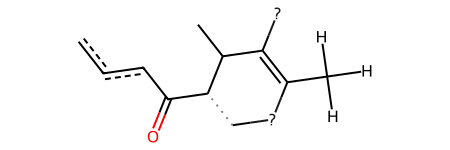

In [26]:
mol_filter_example = Chem.MolFromSmarts(filter_example)
mol_filter_example

In [27]:

inf = open(os.path.join(directory_path,'pains.txt'), "r") # Text file containing PAINS substructures and their descriptions.

sub_strct = [ line.rstrip().split(" ") for line in inf ] # Read each line, strip trailing whitespace, and split by spaces into [SMARTS, description].
smarts = [ line[0] for line in sub_strct] # Extract SMARTS patterns (first element of each line).
desc = [ line[1] for line in sub_strct] # Extract corresponding descriptions (second element of each line).
dic = dict(zip(smarts, desc)) # Create a dictionary mapping SMARTS patterns to their descriptions.

The following functions return lists of those filters which are present in a given molecule (so those for which the molecule *does not pass* the given filter). We only keep molecules for which the lists are empty. 

In [28]:
def pains_filt(mol):
    for k,v in dic.items():
        subs = Chem.MolFromSmarts( k )
        if subs != None:
            if mol.HasSubstructMatch( subs ):
                mol.SetProp(v,k)
    return [ prop for prop in mol.GetPropNames() ]

In [29]:
def passes_wehi_mcf(smi):
    """
    Check if a molecule passes WEHI PAINS and MCF (Medicinal Chemistry Filters).

    This function takes a SMILES string, converts it to an RDKit molecule,
    adds explicit hydrogens, and checks whether it matches any of the
    substructure filters defined in the combined WEHI PAINS and MCF filter set.

    Parameters:
        smi (str): A SMILES representation of the molecule.

    Returns:
        bool: True if the molecule does NOT match any filter (i.e., it "passes"),
              False if it matches at least one filter.
    """
    mol =  Chem.MolFromSmiles(smi)
    h_mol = Chem.AddHs(mol)
    if any(h_mol.HasSubstructMatch(smarts) for smarts in _filters):
        return False 
    else: 
        return True

## $\S 3.$ First examples

We use the above filters on a couple of individual molecules from the BRAF datasets. We also compute their Syba scores. 


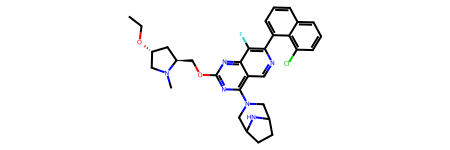

In [30]:
kras_example_smiles = kras_inhibitors_df['smiles'][42]
kras_example_mol = Chem.MolFromSmiles(kras_example_smiles)
kras_example_mol

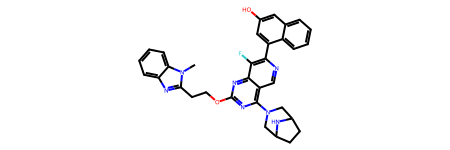

In [31]:
kras_example_smiles_2 = kras_inhibitors_df['smiles'][29]
kras_example_mol_2 = Chem.MolFromSmiles(kras_example_smiles_2)
kras_example_mol_2

In [32]:
kras_example_mol.HasSubstructMatch(mol_filter_example)

False

In [33]:
kras_example_mol_2.HasSubstructMatch(mol_filter_example)

False

In [34]:
pains_filt(kras_example_mol)

[]

In [35]:
pains_filt(kras_example_mol_2)

[]

In [36]:
passes_wehi_mcf(kras_example_smiles)

True

In [37]:
passes_wehi_mcf(kras_example_smiles_2)

True

In [38]:
syba.predict(smi = kras_example_smiles, useChiral=False)

-2.8281636040160305

In [39]:
syba.predict(smi = kras_example_smiles_2, useChiral=False)

42.233894990355225

## $\S 4.$ Fingerprints and similarity

Fingerprints are sparse vector representations of molecules. These are useful for computing similarity scores for pairs of molecules. For a short overview of fingerprints as used bellow see: <a href="https://www.rdkit.org/UGM/2012/Landrum_RDKit_UGM.Fingerprints.Final.pptx.pdf">Fingerprints</a>.

Similarity between fingerprints is computed via Tanimoto Similarity (cf.<a href="https://jcheminf.biomedcentral.com/articles/10.1186/s13321-015-0069-3"> Tanimoto-Similarity </a>).


In [40]:
class _FingerprintCalculator:
    ''' Calculate the fingerprint for a molecule, given the fingerprint type
    Parameters: 
        mol (rdkit.Chem.rdchem.Mol) : RdKit mol object (None if invalid smile string smi)
        fp_type (string)            :Fingerprint type  (choices: AP/PHCO/BPF,BTF,PAT,ECFP4,ECFP6,FCFP4,FCFP6)  
    Returns:
        RDKit fingerprint object
    '''

    def get_fingerprint(self, mol: Mol, fp_type: str):
        method_name = 'get_' + fp_type
        method = getattr(self, method_name)
        if method is None:
            raise Exception(f'{fp_type} is not a supported fingerprint type.')
        return method(mol)

    def get_AP(self, mol: Mol):
        return AllChem.GetAtomPairFingerprint(mol, maxLength=10)

    def get_PHCO(self, mol: Mol):
        return Generate.Gen2DFingerprint(mol, Gobbi_Pharm2D.factory)

    def get_BPF(self, mol: Mol):
        return GetBPFingerprint(mol)

    def get_BTF(self, mol: Mol):
        return GetBTFingerprint(mol)

    def get_PATH(self, mol: Mol):
        return AllChem.RDKFingerprint(mol)

    def get_ECFP4(self, mol: Mol):
        return AllChem.GetMorganFingerprint(mol, 2)

    def get_ECFP6(self, mol: Mol):
        return AllChem.GetMorganFingerprint(mol, 3)

    def get_FCFP4(self, mol: Mol):
        return AllChem.GetMorganFingerprint(mol, 2, useFeatures=True)

    def get_FCFP6(self, mol: Mol):
        return AllChem.GetMorganFingerprint(mol, 3, useFeatures=True)


In [41]:
def get_fingerprint(mol: Mol, fp_type: str):
    ''' Fingerprint getter method. Fingerprint is returned after using object of 
        class '_FingerprintCalculator'
        
    Parameters: 
        mol (rdkit.Chem.rdchem.Mol) : RdKit mol object (None if invalid smile string smi)
        fp_type (string)            :Fingerprint type  (choices: AP/PHCO/BPF,BTF,PAT,ECFP4,ECFP6,FCFP4,FCFP6)  
    Returns:
        RDKit fingerprint object
        
    '''
    return _FingerprintCalculator().get_fingerprint(mol=mol, fp_type=fp_type)


In [42]:
kras_example_fingerprint = get_fingerprint(kras_example_mol, 'ECFP4')
kras_example_fingerprint.GetNonzeroElements()

{31546945: 1,
 36538691: 1,
 98513984: 2,
 169809287: 1,
 211902377: 1,
 277700868: 1,
 312235390: 1,
 411439318: 1,
 448289275: 1,
 517457164: 1,
 594678898: 1,
 699825646: 1,
 862559824: 1,
 864674487: 2,
 882399112: 1,
 951226070: 4,
 963029399: 1,
 1016841875: 1,
 1100037548: 1,
 1101907775: 2,
 1273855569: 1,
 1323063330: 2,
 1323467736: 1,
 1410211760: 1,
 1480777233: 1,
 1486598263: 1,
 1611534139: 1,
 1696524113: 1,
 1759589175: 1,
 1768176847: 1,
 1797620130: 2,
 1856075173: 1,
 1940067849: 1,
 1948213790: 1,
 2014255590: 1,
 2041434490: 3,
 2092489639: 2,
 2115476908: 1,
 2117068077: 2,
 2132511834: 1,
 2245384272: 2,
 2246728737: 2,
 2295519362: 1,
 2360741695: 1,
 2424973678: 1,
 2544815972: 1,
 2559675920: 1,
 2586816684: 1,
 2602113914: 1,
 2811394787: 3,
 2968968094: 6,
 2976033787: 4,
 3043368963: 2,
 3129492592: 1,
 3176806076: 1,
 3217380708: 10,
 3218693969: 7,
 3337745083: 1,
 3452535345: 1,
 3542456614: 1,
 3657471097: 1,
 3692055567: 2,
 3729959637: 1,
 3777168895

In [43]:
kras_example_fingerprint.GetLength()

4294967295

In [44]:
def get_fp_scores(smiles_back, target_smi, fp_type): 
    '''Calculate the Tanimoto fingerprint (using fp_type fingerint) similarity between a list 
       of SMILES and a known target structure (target_smi). 
       
    Parameters:
    smiles_back   (list) : A list of valid SMILES strings 
    target_smi (string)  : A valid SMILES string. Each smile in 'smiles_back' will be compared to this stucture
    fp_type (string)     : Type of fingerprint  (choices: AP/PHCO/BPF,BTF,PAT,ECFP4,ECFP6,FCFP4,FCFP6) 
    
    Returns: 
    smiles_back_scores (list of floats) : List of fingerprint similarities
    '''
    smiles_back_scores = []
    target    = Chem.MolFromSmiles(target_smi)

    fp_target = get_fingerprint(target, fp_type)

    for item in smiles_back: 
        mol    = Chem.MolFromSmiles(item)
        fp_mol = get_fingerprint(mol, fp_type)
        score  = TanimotoSimilarity(fp_mol, fp_target)
        smiles_back_scores.append(score)
    return smiles_back_scores

In [45]:
def similarity_score(smiles_1, smiles_2, fp_type): 
    '''Computes the Tanimoto fingerprint similarity between two smiles. 
    Parameters:
    smiles_1 (string) : A valid SMILES strings 
    smiles_2 (string) : A valid SMILES strings 
    fp_type (string)     : Type of fingerprint  (choices: AP/PHCO/BPF,BTF,PAT,ECFP4,ECFP6,FCFP4,FCFP6)    
    Returns: 
    score (float) : Fingerprint similarities
    '''
    mol_1 = Chem.MolFromSmiles(smiles_1)
    fp_mol_1 = get_fingerprint(mol_1, fp_type)
    mol_2 = Chem.MolFromSmiles(smiles_2)
    fp_mol_2 = get_fingerprint(mol_2, fp_type)
    score  = TanimotoSimilarity(fp_mol_1, fp_mol_2)
    return score

In [46]:
similarity_score(kras_example_smiles, kras_example_smiles_2, "FCFP4")

0.5605095541401274

## $\S 5.$ Some auxiliary functions 

(For the SELFIES representation of a molecules see $\S 6.$ bellow).


In [47]:
def randomize_smiles(mol):
    '''Returns a random (dearomatized) SMILES given an rdkit mol object of a molecule.
    Parameters:
    mol (rdkit.Chem.rdchem.Mol) :  RdKit mol object (None if invalid smile string smi)
    
    Returns:
    mol (rdkit.Chem.rdchem.Mol) : RdKit mol object  (None if invalid smile string smi)
    '''
    if not mol:
        return None

    Chem.Kekulize(mol)
    return rdkit.Chem.MolToSmiles(mol, canonical=False, doRandom=True, isomericSmiles=False,  kekuleSmiles=True) 


In [48]:
def get_selfie_chars(selfie):
    '''Obtain a list of all selfie characters in string selfie
    
    Parameters: 
    selfie (string) : A selfie string - representing a molecule 
    
    Example: 
    >>> get_selfie_chars('[C][=C][C][=C][C][=C][Ring1][Branch1_1]')
    ['[C]', '[=C]', '[C]', '[=C]', '[C]', '[=C]', '[Ring1]', '[Branch1_1]']
    
    Returns:
    chars_selfie: list of selfie characters present in molecule selfie
    '''
    chars_selfie = [] # A list of all SELFIE sybols from string selfie
    while selfie != '':
        chars_selfie.append(selfie[selfie.find('['): selfie.find(']')+1])
        selfie = selfie[selfie.find(']')+1:]
    return chars_selfie


In [49]:
def sanitize_smiles(smi):
    """Return a canonical smile representation of smi
    Parameters:
    smi (string) : smile string to be canonicalized 
    Returns:
    mol (rdkit.Chem.rdchem.Mol) : RdKit mol object                          (None if invalid smile string smi)
    smi_canon (string)          : Canonicalized smile representation of smi (None if invalid smile string smi)
    conversion_successful (bool): True/False to indicate if conversion was  successful 
    """
    try:
        mol = smi2mol(smi, sanitize=True)
        smi_canon = mol2smi(mol, isomericSmiles=False, canonical=True)
        return (mol, smi_canon, True)
    except:
        return (None, None, False)

In [50]:
def get_frags(smi, radius):
    ''' Create fragments from smi with some radius. Remove duplicates and any
    fragments that are blank molecules.
    '''
    mol = smi2mol(smi, sanitize=True)
    frags = []
    for ai in range(mol.GetNumAtoms()):
        env = Chem.FindAtomEnvironmentOfRadiusN(mol, radius, ai)
        amap = {}
        submol = Chem.PathToSubmol(mol, env, atomMap=amap)
        frag = mol2smi(submol, isomericSmiles=False, canonical=True)
        frags.append(frag)
    return list(filter(None, list(set(frags))))

In [51]:
def form_fragments(smi):
    ''' Create fragments of certain radius. Returns a list of fragments
    using SELFIES characters.
    '''
    selfies_frags = []
    unique_frags = get_frags(smi, radius=3)
    for item in unique_frags:
        sf = encoder(item)
        if sf is None:
            continue
        dec_ = decoder(sf)

        try:
            m = Chem.MolFromSmiles(dec_)
            Chem.Kekulize(m)
            dearom_smiles = Chem.MolToSmiles(
                m, canonical=False, isomericSmiles=False, kekuleSmiles=True
            )
            dearom_mol = Chem.MolFromSmiles(dearom_smiles)
        except:
            continue

        if dearom_mol == None:
            raise Exception("mol dearom failes")

        selfies_frags.append(encoder(dearom_smiles))

    return selfies_frags

In [52]:
print(kras_example_mol.GetPropNames())

<rdkit.rdBase._vectclass std::basic_string<char,struct std::char_traits<char>,class std::allocator<char> > object at 0x0000020D563A2D40>


## $\S 6.$ Molecule mutations via STONED-SELFIES

This section introduces the core functions used in this notebook. 

We will rely on the robustness of the SELFIES representation of a molecule in order to generate viable mutations. SELFIES stands for Self-Referencing Embedded Strings. SELFIES are are constructed via a generative grammar that only allows valid molecules. The structural features of this type of representation makes it also ideally suited for Machine Learning routines. See   <a href="https://iopscience.iop.org/article/10.1088/2632-2153/aba947"> SELFIES </a> for more information.  

The `selfies` python module (<a href="https://pypi.org/project/selfies/">pypi.org/project/selfies</a>) includes `encoder` and `decoder` functions to transform SMILES into SELFIES and SELFIES into SMILES. 


We use the SELFIES representation of each molecule in the BRAF inhibitors dataset to generate nearby mutations via the STONED algorithm: 

 <a href="https://chemrxiv.org/engage/chemrxiv/article-details/60c753f00f50db6830397c37"> Superfast Traversal, Optimization, Novelty, Exploration and Discovery (STONED) </a>


In [55]:
source_data_df = source_data_df.dropna(how='any',axis=0) #Drop arrows with NaNs

In [67]:
import selfies

In [68]:
source_data_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 643 entries, 0 to 644
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   id       643 non-null    int64 
 1   SMILES   643 non-null    object
 2   SELFIES  643 non-null    object
dtypes: int64(1), object(2)
memory usage: 20.1+ KB


In [69]:
source_data_df.head()

,id,SMILES,SELFIES
0,1,CN1[C@H](COc2nc3cc(-c4cc(O)cc5ccccc45)ncc3c(N3...,[C][N][C@H1][Branch2][Branch1][=Branch1][C][O]...
1,2,CN1[C@H](COc2nc(N3CC(CC4)NC4C3)c(cnc(-c3cc(O)c...,[C][N][C@H1][Branch2][Branch1][#Branch2][C][O]...
2,3,Cn1c(CCOc2nc(N3CC(CC4)NC4C3)c(cnc(-c3cc(O)cc4c...,[C][N][C][Branch2][Branch1][O][C][C][O][C][=N]...
3,4,Oc1cc2ccccc2c(-c(ncc(c2n3)c(N4CC(CC5)NC5C4)nc3...,[O][C][=C][C][=C][C][=C][C][=C][Ring1][=Branch...
4,5,Cn1nccc1COc1nc(N2CC(CC3)NC3C2)c(cnc(-c2cc(O)cc...,[C][N][N][=C][C][=C][Ring1][Branch1][C][O][C][...


In [70]:
def mutate_selfie(selfie, max_molecules_len, write_fail_cases=False):
    '''Return a mutated selfie string (only one mutation on slefie is performed)
    
    Mutations are done until a valid molecule is obtained 
    Rules of mutation: With a 33.3% propbabily, either: 
        1. Add a random SELFIE character in the string
        2. Replace a random SELFIE character with another
        3. Delete a random character
    
    Parameters:
    selfie            (string)  : SELFIE string to be mutated 
    max_molecules_len (int)     : Mutations of SELFIE string are allowed up to this length
    write_fail_cases  (bool)    : If true, failed mutations are recorded in "selfie_failure_cases.txt"
    
    Returns:
    selfie_mutated    (string)  : Mutated SELFIE string
    smiles_canon      (string)  : canonical smile of mutated SELFIE string
    '''
    valid=False
    fail_counter = 0
    chars_selfie = get_selfie_chars(selfie)
    
    while not valid:
        fail_counter += 1

        alphabet = list(selfies.get_semantic_robust_alphabet()) 

        choice_ls = [1, 2, 3] # 1=Insert; 2=Replace; 3=Delete
        random_choice = np.random.choice(choice_ls, 1)[0]
        
        # Insert a character in a Random Location
        if random_choice == 1: 
            random_index = np.random.randint(len(chars_selfie)+1)
            random_character = np.random.choice(alphabet, size=1)[0]
            
            selfie_mutated_chars = chars_selfie[:random_index] + [random_character] + chars_selfie[random_index:]

        # Replace a random character 
        elif random_choice == 2:                         
            random_index = np.random.randint(len(chars_selfie))
            random_character = np.random.choice(alphabet, size=1)[0]
            if random_index == 0:
                selfie_mutated_chars = [random_character] + chars_selfie[random_index+1:]
            else:
                selfie_mutated_chars = chars_selfie[:random_index] + [random_character] + chars_selfie[random_index+1:]
                
        # Delete a random character
        elif random_choice == 3: 
            random_index = np.random.randint(len(chars_selfie))
            if random_index == 0:
                selfie_mutated_chars = chars_selfie[random_index+1:]
            else:
                selfie_mutated_chars = chars_selfie[:random_index] + chars_selfie[random_index+1:]
                
        else: 
            raise Exception('Invalid Operation trying to be performed')

        selfie_mutated = "".join(x for x in selfie_mutated_chars)
        sf = "".join(x for x in chars_selfie)
        
        try:
            smiles = decoder(selfie_mutated)
            mol, smiles_canon, done = sanitize_smiles(smiles)
            if len(selfie_mutated_chars) > max_molecules_len or smiles_canon=="":
                done = False
            if done:
                valid = True
            else:
                valid = False
        except:
            valid=False
            if fail_counter > 1 and write_fail_cases == True:
                f = open("selfie_failure_cases.txt", "a+")
                f.write('Tried to mutate SELFIE: '+str(sf)+' To Obtain: '+str(selfie_mutated) + '\n')
                f.close()
    
    return (selfie_mutated, smiles_canon)


In [71]:
kras_example_selfies = sf.encoder(kras_example_smiles)
kras_example_selfies

'[C][C][O][C@H1][C][N][Branch1][C][C][C@H1][Branch2][Branch1][#Branch2][C][O][C][=N][C][Branch1][#C][N][C][C][Branch1][Ring1][C][C][N][C][Ring1][Ring1][C][Ring1][Branch2][=C][Branch2][Ring1][#Branch2][C][=N][C][Branch2][Ring1][C][C][=C][C][Branch1][C][Cl][=C][C][=C][C][Ring1][#Branch1][=C][C][=C][Ring1][O][=C][F][C][Ring1][Ring1][=N][Ring2][Ring1][=C][C][Ring2][Ring2][=Branch1]'

In [72]:
len_kras_example = len(get_selfie_chars(kras_example_selfies))
len_kras_example

74

In [73]:
mutated_kras_example =  mutate_selfie(kras_example_selfies, len_kras_example, write_fail_cases=False)

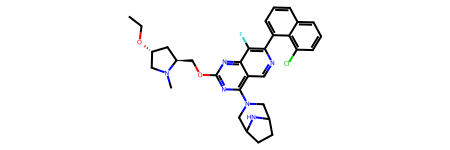

In [74]:
kras_example_mol

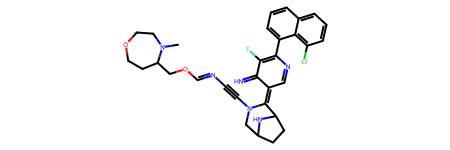

In [75]:
Chem.MolFromSmiles(mutated_kras_example[1])

In [76]:
passes_wehi_mcf(mutated_kras_example[1])

True

In [77]:
syba.predict(smi = mutated_kras_example[1], useChiral=False)

-106.39140534529822

In [78]:
similarity_score(mutated_kras_example[1], kras_example_smiles, 'FCFP4')

0.391812865497076

In [79]:
def depth_n_selfies_mutation(selfies, depth):
    '''Mutates a molecule n consecutive times returning the SMILES representation of the resulting mutation:
       Parameters:
       smiles (string) : A valid SMILES string 
       depth (int): total number of consecutive mutations
       Returns: 
       mutation (string) : mutated string
       '''
    origin_selfies = selfies
    len_origin = len(get_selfie_chars(origin_selfies))
    mutations_list = [origin_selfies]
    for i in range(depth):
        old_selfie = mutations_list[i]
        new_selfie = mutate_selfie(old_selfie, len_origin + depth, write_fail_cases=False)[0]
        mutations_list.append(new_selfie)
    mutation = mutations_list[-1]
    return mutation

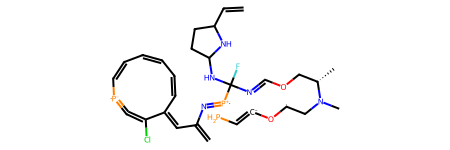

In [80]:
n_mutated_kras_example_selfies = depth_n_selfies_mutation(kras_example_selfies, 6)
n_mutated_kras_example_smiles = selfies.decoder(n_mutated_kras_example_selfies)
Chem.MolFromSmiles(n_mutated_kras_example_smiles)

The following is our main function, it computes valid molecule mutations that pass the wehi_mcf test. It also computes their syba scores. 

In [81]:
def get_mutated_molecules(selfies, num_mutations, max_depth = 5, fp_type = 'FCFP4', similarity_treshold = 0.5, positive_syba = False): 
    '''Compute a list of valid mutated molecules via STONED-SELFIES
       Parameters:
       smiles (str) : A valid SMILES string 
       num_mutations (int): total number of mutations of the original molecule
       max_depth (int): max number of consecutive mutations to be applied  
       fp_type (str)     :  type of fingerprint to measure similarity (choices: AP/PHCO/BPF,BTF,PAT,ECFP4,ECFP6,FCFP4,FCFP6) 
       positive_syba (bool): If true  only molecules with positive syba score are generated.  
       Returns: 
       mutations (list): list of mutations
       Each mutation in the list consist of a dictionary with keys 'SELFIES', 'SMILES','sim_score', 'syba_score'.
       '''
    origin_selfies = selfies
    origin_smiles = decoder(origin_selfies)
    mutations = []
    total_molecule_count = 0
    while total_molecule_count < num_mutations:
        mutation = {}
        depth = random.randint(1, max_depth)
        mutated_selfies = depth_n_selfies_mutation(origin_selfies, depth)
        mutated_smiles = decoder(mutated_selfies)
        test = passes_wehi_mcf(mutated_smiles)
        similarity = similarity_score(mutated_smiles, origin_smiles, fp_type)
        if test and (similarity >= similarity_treshold):
            mutation['SELFIES'] = mutated_selfies
            mutation['SMILES'] = mutated_smiles
            mutation['syba_score'] = syba.predict(smi = mutated_smiles, useChiral=False)
            mutation['sim_score'] = similarity 
            mutation['ori_or_mut'] = 'Mutation'
            mutations.append(mutation)
            total_molecule_count += 1
    return mutations
    


#### Example:

In [82]:
mutations_list_example = get_mutated_molecules(kras_example_selfies, 5)

In [83]:
mutations_list_example_df = pd.DataFrame(mutations_list_example)

In [84]:
mutations_list_example_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5 entries, 0 to 4
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   SELFIES     5 non-null      object 
 1   SMILES      5 non-null      object 
 2   syba_score  5 non-null      float64
 3   sim_score   5 non-null      float64
 4   ori_or_mut  5 non-null      object 
dtypes: float64(2), object(3)
memory usage: 332.0+ bytes


In [85]:
mutations_list_example_df.head()

,SELFIES,SMILES,syba_score,sim_score,ori_or_mut
0,[C][C][O][C@H1][C][N][Branch1][C][C][=S+1][C@H...,CCO[C@H1]C1N(C)[S+1][C@H1](COC2=NC(N3CC(CC4)NC...,-7.813420,0.798507,Mutation
1,[=N-1][C][C][O][C@H1][C][N][Branch1][C][C][C@H...,[N-1]CCO[C@H1]1CN(C)[C@H1](COC2=NC(N3CC(CC4)NC...,1.207736,0.959350,Mutation
2,[C][C][O][C@H1][C][N][Branch1][C][C][C@H1][Bra...,CCO[C@H1]CN(C)[C@H1](COC1=NC(N2CC(CC3)NC3C2)=C...,5.344695,0.896000,Mutation
3,[C][C][O][C@H1][C][N][Branch1][C][C][C@H1][Bra...,C1CO[C@H1]CN(C)[C@H1](COC2=NC(N3CC(CC4)NC4C3)=...,-4.661100,0.861538,Mutation
4,[C][C][O][C@H1][#P+1][N][Branch1][C][C][C@H1][...,CCO[C@H1]=[P+1]N(C)[C@H1](COC1=NC(N2CC(CC3)NC3...,3.438097,0.809160,Mutation


Before constructing the full dataset, which will contain 643 original molecules together with N = 49 mutations for each of them, we do a toy example where we give 5 mutations of the first three molecules.  

In [86]:
molecule_neighborhood_list = []

for index, molecule in source_data_df.head(3).iterrows():
    parent_id = molecule['id']
    molecule_neighborhood =[]
    base_selfies =  molecule['SELFIES']
    base_smiles = decoder(base_selfies)
    base_dic = {}
    base_dic['SELFIES'] = base_selfies
    base_dic['SMILES'] = base_selfies
    base_dic['syba_score'] = syba.predict(smi = base_smiles, useChiral=False)
    base_dic['sim_score'] = 1.0
    base_dic['ori_or_mut'] = 'Original'
    molecule_neighborhood.append(base_dic)

    mutations_list = get_mutated_molecules(base_selfies, 5)
    molecule_neighborhood.extend(mutations_list)
    
    molecule_neighborhood_df = pd.DataFrame(molecule_neighborhood)
    molecule_neighborhood_df['parent_id'] = parent_id
    
    molecule_neighborhood_list.append(molecule_neighborhood_df)

In [87]:
toy_example_df = pd.concat(molecule_neighborhood_list, ignore_index=True)
toy_example_df.reset_index(inplace=True)

In [88]:
toy_example_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18 entries, 0 to 17
Data columns (total 7 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   index       18 non-null     int64  
 1   SELFIES     18 non-null     object 
 2   SMILES      18 non-null     object 
 3   syba_score  18 non-null     float64
 4   sim_score   18 non-null     float64
 5   ori_or_mut  18 non-null     object 
 6   parent_id   18 non-null     int64  
dtypes: float64(2), int64(2), object(3)
memory usage: 1.1+ KB


In [89]:
toy_example_df.head(18)

,index,SELFIES,SMILES,syba_score,sim_score,ori_or_mut,parent_id
0,0,[C][N][C@H1][Branch2][Branch1][=Branch1][C][O]...,[C][N][C@H1][Branch2][Branch1][=Branch1][C][O]...,-3.210813,1.000000,Original,1
1,1,[C][N][#P-1][Branch2][Branch1][=Branch1][C][O]...,CN=[P-1](COC1=NC2=CC(C3=CC(O)=CC4=CC=CC=C34)=N...,-13.016568,0.823529,Mutation,1
2,2,[C][N][C@H1][Branch2][Branch1][=Branch1][C][C]...,C1N[C@H1](CC2=NC3=CC(C4=CC(O)=CC5=CC=CC=C45)=N...,-29.576282,0.717742,Mutation,1
3,3,[C][N][C@H1][Branch2][Branch1][=Branch1][C][O]...,CN[C@H1](CO[C+1]C1=NC2=CC(C3=CC(O)=CC4=CC=CC=C...,-5.757322,0.718750,Mutation,1
4,4,[C][N][C@H1][Branch2][Branch1][=Branch1][C][O]...,CN1[C@H1](COC2=NC=C(C3=CC(O)=CC4=CC=CC=C34)NC=...,36.710146,0.572464,Mutation,1
5,5,[C][N][C@H1][Branch2][Branch1][=Branch1][C][O]...,CN[C@H1](COC=NC1=CC(C2=CC(O)=CC3=CC=CC=C23)=NC...,-10.579858,0.528571,Mutation,1
6,6,[C][N][C@H1][Branch2][Branch1][#Branch2][C][O]...,[C][N][C@H1][Branch2][Branch1][#Branch2][C][O]...,-4.137766,1.000000,Original,2
7,7,[C][N][C@H1][Branch2][Branch1][#Branch2][C][O]...,CN1[C@H1](COC2=NC(N3CC(CC4)NC4C3)=C(C#CNC(C5=C...,5.331684,0.669173,Mutation,2
8,8,[C][N][C@H1][Branch2][Branch1][#Branch2][C][O]...,CN1[C@H1](COC2=NC(NCC(CC3)NC3=C)=C(C=NC(C4=CC(...,8.616658,0.753968,Mutation,2
9,9,[C][N][C@H1][Branch2][Branch1][#Branch2][C][O]...,CN1[C@H1](COC2=NC(N3CC(CC4)NC4C3)=C(C=NC(C=CC(...,-91.895089,0.632353,Mutation,2


In [90]:
kras_inhibitors_toy_example = os.path.join(directory_path, 'kras_inhibitors_toy_example.csv')

In [91]:
toy_example_df.to_csv(kras_inhibitors_toy_example, index=False)

## $\S 7.$ Data augmentation via STONED-SELFIES

We use the above tools to explore the local chemical subspaces of molecules nearby KRAS-inhibitors.

From each BRAF inhibitor we form 

N = 9

mutations to obtain a neighborhood consisting of 10  potential KRAS inhibitors. The resulting dataset is written to the file `KRAS_inhibitors_augmented.csv`. 

Here for each molecule we have:
- index: a unique integer index.
- SELFIES: the molecule's SELFIES representation. 
- SMILES: the molecule's SMILES representation. 
- syba_score: the molecule's syba_score. 
- sim_score: the molecule's similarity to its parent molecule. 
- ori_or_mut: 'Original' or 'Mutation'. 
- parent_id: the molecule's parent id as per the original initial dataset.

This computation is just an example meant to provide a small, tenfolded, training dataset. The parameter N can be adjusted according to the needs of a given workflow. This parameter determines the size of the training dataset used further in the pipeline. For a full workflow with enough resources N ~ 1000 is recommended. 


In [96]:
N = 9

In [97]:
molecule_neighborhood_list = []

for index, molecule in source_data_df.iterrows():
    parent_id = molecule['id']
    molecule_neighborhood =[]
    base_selfies =  molecule['SELFIES']
    base_smiles = decoder(base_selfies)
    base_dic = {}
    base_dic['SELFIES'] = base_selfies
    base_dic['SMILES'] = base_selfies
    base_dic['syba_score'] = syba.predict(smi = base_smiles, useChiral=False)
    base_dic['sim_score'] = 1.0
    base_dic['ori_or_mut'] = 'Original'
    molecule_neighborhood.append(base_dic)

    mutations_list = get_mutated_molecules(base_selfies, N)
    molecule_neighborhood.extend(mutations_list)
    
    molecule_neighborhood_df = pd.DataFrame(molecule_neighborhood)
    molecule_neighborhood_df['parent_id'] = parent_id
    
    molecule_neighborhood_list.append(molecule_neighborhood_df)

In [98]:
len(molecule_neighborhood_list)

643

In [99]:
KRAS_inhibitors_augmented_df = pd.concat(molecule_neighborhood_list, ignore_index=True)
KRAS_inhibitors_augmented_df.reset_index(inplace=True)

In [100]:
KRAS_inhibitors_augmented_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6430 entries, 0 to 6429
Data columns (total 7 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   index       6430 non-null   int64  
 1   SELFIES     6430 non-null   object 
 2   SMILES      6430 non-null   object 
 3   syba_score  6430 non-null   float64
 4   sim_score   6430 non-null   float64
 5   ori_or_mut  6430 non-null   object 
 6   parent_id   6430 non-null   int64  
dtypes: float64(2), int64(2), object(3)
memory usage: 351.8+ KB


In [101]:
KRAS_inhibitors_augmented_df.head()

,index,SELFIES,SMILES,syba_score,sim_score,ori_or_mut,parent_id
0,0,[C][N][C@H1][Branch2][Branch1][=Branch1][C][O]...,[C][N][C@H1][Branch2][Branch1][=Branch1][C][O]...,-3.210813,1.000000,Original,1
1,1,[C][N][C@H1][Branch2][Branch1][=Branch1][C][O]...,CN[C@H1](COC1=NC2=CC(C3=CC(O)=CC4=CC=CC=C34)=N...,-2.508838,0.823529,Mutation,1
2,2,[C][N][C@H1][Branch2][Branch1][=Branch1][C][O]...,C1N[C@H1](COC2=NC3=CC(C4=CC(O)=CC5=CC=CC=C45)=...,-34.896138,0.815126,Mutation,1
3,3,[C][N][C@H1][Branch2][Branch1][=Branch1][C][O]...,CN[C@H1](C1OC2=NC3=CC(C4=CC(O)=CC5=CC=CC=C45)=...,-11.168379,0.786885,Mutation,1
4,4,[C][N][C@H1][Branch2][Branch1][=Branch1][C][O]...,CN[C@H1](COC1=NC2=CC(C3=CC(O)=CC4=CC=CC=C34)=N...,-13.991922,0.788618,Mutation,1


In [103]:
KRAS_inhibitors_augmented = os.path.join(directory_path, 'KRAS_inhibitors_augmented.csv')

In [104]:
KRAS_inhibitors_augmented_df.to_csv(KRAS_inhibitors_augmented, index=False)